In [1]:
import os
from pathlib import Path
import random
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, top_k_accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import hog
from tensorflow.keras import layers, models, callbacks, utils, applications
import tensorflow as tf
from tqdm import tqdm

print('numpy', np.__version__)
print('opencv', cv2.__version__)
print('tensorflow', tf.__version__)

numpy 2.2.6
opencv 4.12.0
tensorflow 2.20.0


In [2]:
# Paths and basic dataset discovery
DATA_ROOT = Path('d:/Code/AI/Face Recognition using Iris scanning/CASIA-Iris-Interval')
# Ensure your working dir contains the `CASIA-Iris-Interval` folder.
print('Dataset root:', DATA_ROOT.resolve())

# gather class folders (numeric IDs)
classes = [p.name for p in sorted(DATA_ROOT.iterdir()) if p.is_dir()]
print('Found', len(classes), 'class folders (showing first 20):', classes[:20])

Dataset root: D:\Code\AI\Face Recognition using Iris scanning\CASIA-Iris-Interval
Found 249 class folders (showing first 20): ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020']


In [3]:
# Utility: load images and labels from the folder structure (L and R subfolders contain images)
def load_dataset(root, max_per_class=None, image_size=(128,128)):
    X = []
    y = []
    root = Path(root)
    class_dirs = [p for p in sorted(root.iterdir()) if p.is_dir()]
    for c in class_dirs:
        imgs = list(c.rglob('*.tif')) + list(c.rglob('*.png')) + list(c.rglob('*.jpg'))
        if max_per_class:
            imgs = imgs[:max_per_class]
        for f in imgs:
            img = cv2.imread(str(f), cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, image_size, interpolation=cv2.INTER_AREA)
            X.append(img)
            y.append(c.name)
    X = np.array(X)
    y = np.array(y)
    return X, y

# Quick load small subset for experimentation (set max_per_class larger for full training)
X, y = load_dataset(DATA_ROOT, max_per_class=10, image_size=(128,128))
print('Loaded', X.shape, 'labels', y.shape)

Loaded (1914, 128, 128) labels (1914,)


Sample class counts (few shown): [(np.str_('001'), 10), (np.str_('002'), 10), (np.str_('003'), 7), (np.str_('004'), 7), (np.str_('005'), 8), (np.str_('006'), 7), (np.str_('007'), 10), (np.str_('008'), 10), (np.str_('009'), 9), (np.str_('010'), 5)]


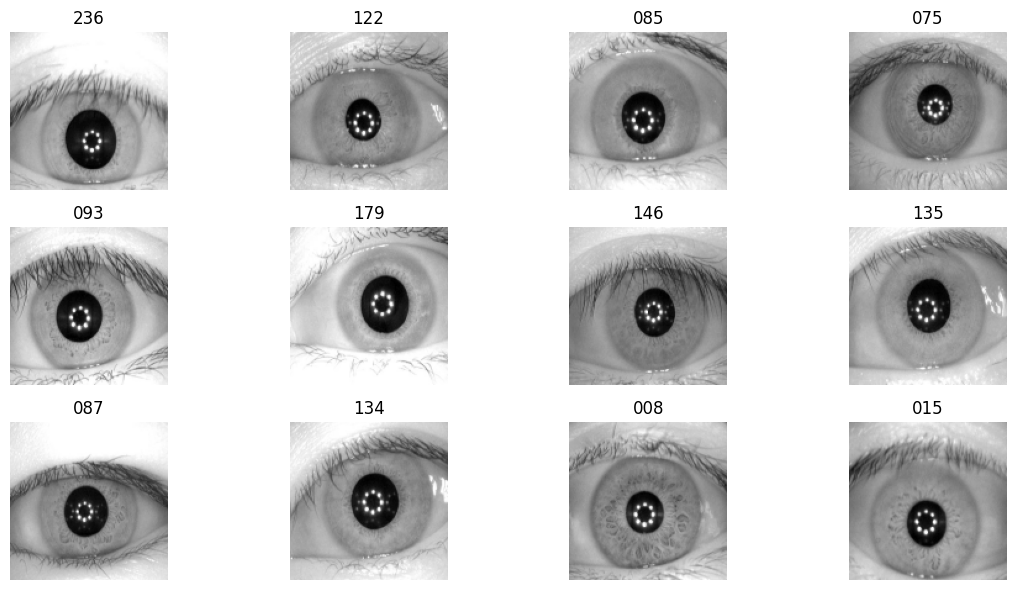

In [4]:
# Show sample images and class distribution
def show_samples(X, y, n=12):
    idx = np.random.choice(len(X), min(n, len(X)), replace=False)
    plt.figure(figsize=(12,6))
    for i,k in enumerate(idx,1):
        plt.subplot(3,4,i); plt.imshow(X[k], cmap='gray'); plt.title(y[k]); plt.axis('off')
    plt.tight_layout()

show_samples(X,y)

# class counts
from collections import Counter
counts = Counter(y)
print('Sample class counts (few shown):', list(counts.items())[:10])

## Preprocessing helpers

We include simple preprocessing: histogram equalization, optional circular crop around the center (simple heuristic). For production/classroom pipeline you should replace heuristic cropping with a robust iris localization method (Daugman integro-differential, U-Net or specialized iris segmentation).


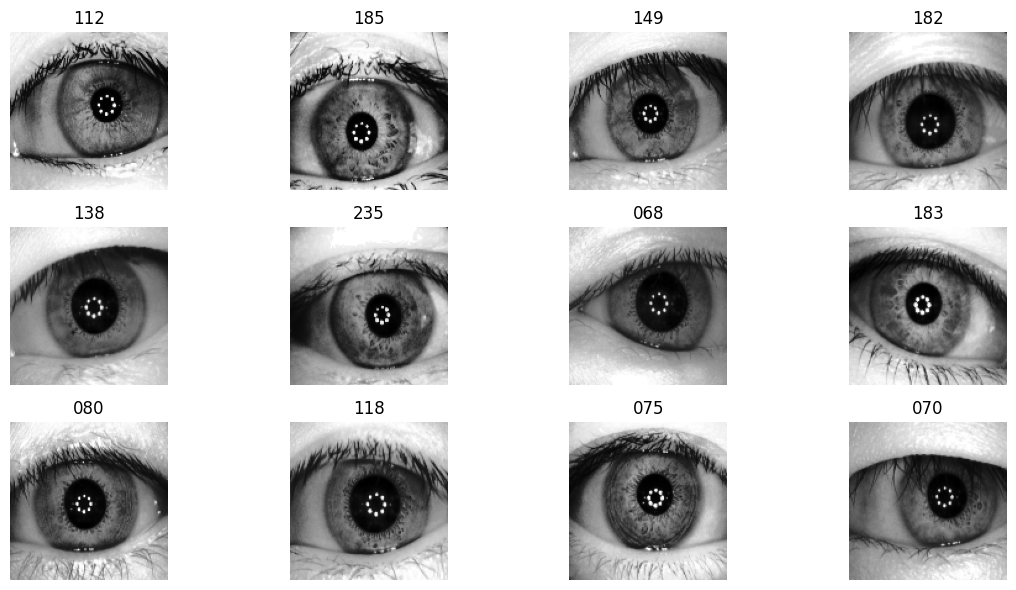

In [5]:
def preprocess(img, equalize=True, clip_size=(128,128)):
    # img expected grayscale
    out = img.copy()
    if equalize:
        out = cv2.equalizeHist(out)
    out = cv2.resize(out, clip_size)
    return out

# Apply to small dataset sample
Xp = np.array([preprocess(im) for im in X])
show_samples(Xp, y)

## Classical features: HOG + SVM/RandomForest

We'll extract HOG descriptors and train a simple SVM classifier as a baseline.


In [6]:
def extract_hog_batch(X, pixels_per_cell=(16,16)):
    feats = []
    for im in X:
        fd = hog(im, orientations=9, pixels_per_cell=pixels_per_cell, cells_per_block=(2,2), feature_vector=True)
        feats.append(fd)
    return np.array(feats)

# Prepare data (use more images for final runs)
X_full, y_full = load_dataset(DATA_ROOT, max_per_class=25, image_size=(128,128))
# check class sample counts — train_test_split stratify requires >=2 samples per class
from collections import Counter
counts = Counter(y_full)
min_count = min(counts.values()) if counts else 0
if min_count < 2:
    n_too_few = sum(1 for v in counts.values() if v < 2)
    print(f'Warning: {n_too_few} classes have fewer than 2 samples — filtering them out for stratified split')
    valid = {k for k,v in counts.items() if v >= 2}
    mask = np.array([lbl in valid for lbl in y_full])
    X_full = X_full[mask]
    y_full = y_full[mask]
    counts = Counter(y_full)
    print('After filtering, samples:', len(y_full), 'classes:', len(counts))

# Ensure a canonical LabelEncoder `le_master` is used/created and registered
le_used = globals().get('le_master')
if le_used is None:
    # Try to load a persisted le_master first
    try:
        import joblib
        le_path = OUT_DIR / 'le_master.joblib'
        if le_path.exists():
            le_used = joblib.load(le_path)
            globals()['le_master'] = le_used
            print('Loaded le_master from', le_path)
    except Exception:
        le_used = None
if le_used is None:
    # Create and register the canonical encoder from current labels
    le_used = LabelEncoder().fit(y_full)
    globals()['le_master'] = le_used
    print('Created and registered le_master with', len(getattr(le_used, 'classes_', [])), 'classes')
else:
    print('Using existing le_master with', len(getattr(le_used, 'classes_', [])), 'classes')

# keep legacy variable name `le` for compatibility
le = le_used
y_enc = le.transform(y_full)
print('Classes:', len(le.classes_))

X_hog = extract_hog_batch(X_full)
print('HOG shape', X_hog.shape)

# attempt a stratified split; if it fails (still too few samples), fall back to an unstratified split
try:
    X_train, X_test, y_train, y_test = train_test_split(X_hog, y_enc, stratify=y_enc, test_size=0.2, random_state=42)
except ValueError as e:
    print('Stratified split failed:', e)
    print('Falling back to non-stratified split')
    X_train, X_test, y_train, y_test = train_test_split(X_hog, y_enc, test_size=0.2, random_state=42)

svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)
# classification_report requires target_names to match the labels present in y_true/y_pred
present_labels = np.unique(np.concatenate([y_test, y_pred]))
target_names = le.inverse_transform(present_labels).tolist()
print(classification_report(y_test, y_pred, labels=present_labels.tolist(), target_names=target_names))
print('Accuracy (HOG+SVM):', accuracy_score(y_test, y_pred))

After filtering, samples: 2621 classes: 246
Created and registered le_master with 246 classes
Classes: 246
HOG shape (2621, 1764)
HOG shape (2621, 1764)
              precision    recall  f1-score   support

         001       1.00      1.00      1.00         4
         002       1.00      0.50      0.67         4
         003       0.50      1.00      0.67         1
         004       0.00      0.00      0.00         1
         005       1.00      0.50      0.67         2
         006       1.00      1.00      1.00         1
         007       0.75      0.75      0.75         4
         008       1.00      1.00      1.00         4
         009       1.00      1.00      1.00         2
         010       1.00      1.00      1.00         1
         011       0.80      1.00      0.89         4
         012       0.50      1.00      0.67         1
         013       1.00      1.00      1.00         1
         014       0.50      1.00      0.67         1
         015       1.00      1.00   

c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

## Deep learning: Small CNN (from scratch)

A small proof-of-concept CNN. For full-scale training please increase dataset size, use class-balanced sampling and train longer with GPU.


In [7]:
# Prepare image arrays and labels for Keras models (use more images in real training)
X_imgs, y_imgs = load_dataset(DATA_ROOT, max_per_class=60, image_size=(128,128))
# check class counts and filter classes with fewer than 2 samples (needed for stratified splits)
from collections import Counter
counts_cnn = Counter(y_imgs)
min_count_cnn = min(counts_cnn.values()) if counts_cnn else 0
if min_count_cnn < 2:
    n_too_few = sum(1 for v in counts_cnn.values() if v < 2)
    print(f'Warning: {n_too_few} classes have fewer than 2 samples — filtering them out for stratified split')
    valid_c = {k for k,v in counts_cnn.items() if v >= 2}
    mask_c = np.array([lbl in valid_c for lbl in y_imgs])
    X_imgs = X_imgs[mask_c]
    y_imgs = y_imgs[mask_c]
    counts_cnn = Counter(y_imgs)
    print('After filtering, samples:', len(y_imgs), 'classes:', len(counts_cnn))

# Ensure canonical LabelEncoder `le_master` is used/created and registered
le_used = globals().get('le_master')
if le_used is None:
    try:
        import joblib
        le_path = OUT_DIR / 'le_master.joblib'
        if le_path.exists():
            le_used = joblib.load(le_path)
            globals()['le_master'] = le_used
            print('Loaded le_master from', le_path)
    except Exception:
        le_used = None
if le_used is None:
    le_used = LabelEncoder().fit(y_imgs)
    globals()['le_master'] = le_used
    print('Created and registered le_master with', len(getattr(le_used, 'classes_', [])), 'classes')
else:
    print('Using existing le_master with', len(getattr(le_used, 'classes_', [])), 'classes')

# encode labels after filtering
le = le_used
y_idxs = le.transform(y_imgs)
X_imgs = np.expand_dims(X_imgs, -1) / 255.0
num_classes = len(np.unique(y_idxs))
print('Images shape', X_imgs.shape, 'Num classes', num_classes)

# Use a small train/val/test split — try stratified, fall back to non-stratified if necessary
try:
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X_imgs, y_idxs, stratify=y_idxs, test_size=0.3, random_state=42)
except ValueError as e:
    print('Stratified split failed for CNN data:', e)
    print('Falling back to non-stratified split')
    X_tr, X_tmp, y_tr, y_tmp = train_test_split(X_imgs, y_idxs, test_size=0.3, random_state=42)

# second split for validation/test, try stratified if possible
try:
    X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, stratify=y_tmp, test_size=0.5, random_state=42)
except Exception:
    X_val, X_te, y_val, y_te = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

def make_small_cnn(input_shape=(128,128,1), n_classes=10):
    inp = layers.Input(shape=input_shape)
    x = layers.Conv2D(32,3,activation='relu',padding='same')(inp)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
    x = layers.MaxPool2D(2)(x)
    x = layers.Conv2D(128,3,activation='relu',padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    out = layers.Dense(n_classes, activation='softmax')(x)
    model = models.Model(inp, out)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

cnn = make_small_cnn(input_shape=X_tr.shape[1:], n_classes=num_classes)
cnn.summary()
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = cnn.fit(X_tr, y_tr, validation_data=(X_val, y_val), epochs=20, batch_size=32, callbacks=[es])
te_pred = np.argmax(cnn.predict(X_te), axis=1)
# classification_report for CNN: only include present labels if needed
try:
    print('CNN test accuracy', accuracy_score(y_te, te_pred))
    present = np.unique(np.concatenate([y_te, te_pred]))
    names = le.inverse_transform(present).tolist()
    print(classification_report(y_te, te_pred, labels=present.tolist(), target_names=names))
except Exception as e:
    print('Error printing classification report:', e)
    print(classification_report(y_te, te_pred))

After filtering, samples: 2636 classes: 246
Using existing le_master with 246 classes
Images shape (2636, 128, 128, 1) Num classes 246


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 246)            │        31,734 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,406 (485.96 KB)

 Trainable params: 124,406 (485.96 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 18s 288ms/step - accuracy: 0.0076 - loss: 5.4975 - val_accuracy: 0.0152 - val_loss: 5.4512
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 18s 288ms/step - accuracy: 0.0076 - loss: 5.4975 - val_accuracy: 0.0152 - val_loss: 5.4512
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - accuracy: 0.0136 - loss: 5.4313 - val_accuracy: 0.0152 - val_loss: 5.3917
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 280ms/step - accuracy: 0.0136 - loss: 5.4313 - val_accuracy: 0.0152 - val_loss: 5.3917
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 17s 286ms/step - accuracy: 0.0136 - loss: 5.4043 - val_accuracy: 0.0152 - val_loss: 5.3685
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 17s 286ms/step - accuracy: 0.0136 - loss: 5.4043 - val_accuracy: 0.0152 - val_loss: 5.3685
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 279ms/step - accuracy: 0.0130 - loss: 5.3831 - val_accuracy: 0.0152 - val_loss: 5.3665
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 16s 279ms/step - accuracy: 0.0130 - loss: 5.3831 - val_accu

c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
c:\Users\sirad\AppData\Loca

## Transfer learning: MobileNetV2

Use MobileNetV2 as a feature extractor — faster and effective for small datasets.


In [8]:
IMG_SIZE = 160
# reload images at MobileNet input size with 3 channels for pretrained models
def load_rgb(root, max_per_class=None, image_size=(IMG_SIZE,IMG_SIZE)):
    X=[]; y=[]
    root = Path(root)
    for c in sorted(root.iterdir()):
        if not c.is_dir(): continue
        imgs = list(c.rglob('*.tif')) + list(c.rglob('*.png')) + list(c.rglob('*.jpg'))
        if max_per_class: imgs = imgs[:max_per_class]
        for f in imgs:
            im = cv2.imread(str(f))
            if im is None: continue
            im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
            im = cv2.resize(im, image_size)
            X.append(im)
            y.append(c.name)
    return np.array(X), np.array(y)

X_rgb, y_rgb = load_rgb(DATA_ROOT, max_per_class=60, image_size=(IMG_SIZE,IMG_SIZE))
# check class counts and filter classes with fewer than 2 samples to allow stratified split
from collections import Counter
counts_rgb = Counter(y_rgb)
min_count_rgb = min(counts_rgb.values()) if counts_rgb else 0
if min_count_rgb < 2:
    n_too_few = sum(1 for v in counts_rgb.values() if v < 2)
    print(f'Warning: {n_too_few} classes have fewer than 2 samples — filtering them out for stratified split')
    valid_rgb = {k for k,v in counts_rgb.items() if v >= 2}
    mask_rgb = np.array([lbl in valid_rgb for lbl in y_rgb])
    X_rgb = X_rgb[mask_rgb]
    y_rgb = y_rgb[mask_rgb]
    counts_rgb = Counter(y_rgb)
    print('After filtering, samples:', len(y_rgb), 'classes:', len(counts_rgb))

# Ensure canonical LabelEncoder `le_master` is used/created and registered
le_used = globals().get('le_master')
if le_used is None:
    try:
        import joblib
        le_path = OUT_DIR / 'le_master.joblib'
        if le_path.exists():
            le_used = joblib.load(le_path)
            globals()['le_master'] = le_used
            print('Loaded le_master from', le_path)
    except Exception:
        le_used = None
if le_used is None:
    le_used = LabelEncoder().fit(y_rgb)
    globals()['le_master'] = le_used
    print('Created and registered le_master with', len(getattr(le_used, 'classes_', [])), 'classes')
else:
    print('Using existing le_master with', len(getattr(le_used, 'classes_', [])), 'classes')

le2 = le_used
y2 = le2.transform(y_rgb)
X_rgb = X_rgb.astype('float32')/255.0
n_classes2 = len(np.unique(y2))

# try stratified split, fall back to non-stratified if it fails
try:
    Xtr, Xtmp, ytr, ytmp = train_test_split(X_rgb, y2, stratify=y2, test_size=0.3, random_state=42)
except ValueError as e:
    print('Stratified split failed for TL data:', e)
    print('Falling back to non-stratified split')
    Xtr, Xtmp, ytr, ytmp = train_test_split(X_rgb, y2, test_size=0.3, random_state=42)
# second split for val/test — try stratified then fallback
try:
    Xval, Xte, yval, yte = train_test_split(Xtmp, ytmp, stratify=ytmp, test_size=0.5, random_state=42)
except Exception:
    Xval, Xte, yval, yte = train_test_split(Xtmp, ytmp, test_size=0.5, random_state=42)

base = applications.MobileNetV2(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
base.trainable = False
inp = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = base(inp, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(n_classes2, activation='softmax')(x)
tl_model = models.Model(inp, out)
tl_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
tl_model.summary()
es2 = callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
tl_history = tl_model.fit(Xtr, ytr, validation_data=(Xval,yval), epochs=12, batch_size=32, callbacks=[es2])
preds = np.argmax(tl_model.predict(Xte), axis=1)
print('Transfer test acc:', accuracy_score(yte, preds))
# Make classification_report robust: only include labels present in test/pred
present_tl = np.unique(np.concatenate([yte, preds]))
tl_target_names = le2.inverse_transform(present_tl).tolist()
print(classification_report(yte, preds, labels=present_tl.tolist(), target_names=tl_target_names))

After filtering, samples: 2636 classes: 246
Using existing le_master with 246 classes


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 246)            │       315,126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,573,110 (9.82 MB)

 Trainable params: 315,126 (1.20 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 402ms/step - accuracy: 0.0466 - loss: 5.7987 - val_accuracy: 0.3190 - val_loss: 3.7155
Epoch 2/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 28s 402ms/step - accuracy: 0.0466 - loss: 5.7987 - val_accuracy: 0.3190 - val_loss: 3.7155
Epoch 2/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.3463 - loss: 3.2099 - val_accuracy: 0.6608 - val_loss: 2.2685
Epoch 3/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 370ms/step - accuracy: 0.3463 - loss: 3.2099 - val_accuracy: 0.6608 - val_loss: 2.2685
Epoch 3/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.6423 - loss: 1.8246 - val_accuracy: 0.8278 - val_loss: 1.4663
Epoch 4/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step - accuracy: 0.6423 - loss: 1.8246 - val_accuracy: 0.8278 - val_loss: 1.4663
Epoch 4/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.8255 - loss: 1.0944 - val_accuracy: 0.8962 - val_loss: 1.0419
Epoch 5/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 21s 369ms/step - accuracy: 0.8255 - loss: 1.0944 - val_accu

c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
c:\Users\sirad\AppData\Loca

## Evaluation utilities and comparison

Compute confusion matrix and top-K accuracy for the best models.


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)


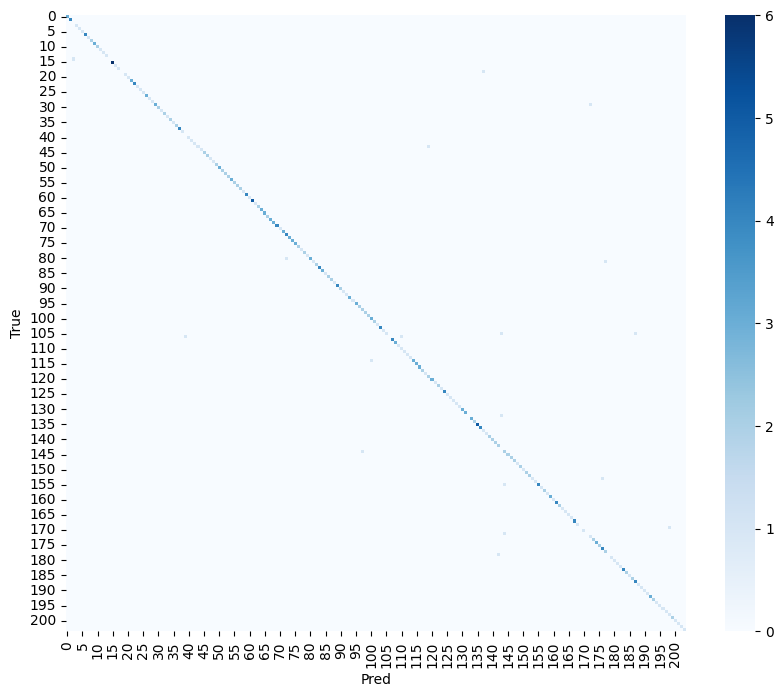

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 283ms/step
Top-3 accuracy: 0.9797979797979798
Top-3 accuracy: 0.9797979797979798


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_ranking.py:1998: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  y_type = type_of_target(y_true, input_name="y_true")


In [9]:
import seaborn as sns
def plot_confusion(y_true, y_pred, labels=None, figsize=(10,8)):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
    plt.ylabel('True'); plt.xlabel('Pred');
    plt.show()

# Example: plot for transfer learning model results
plot_confusion(yte, preds)
# top-k example (k=3)
tl_probs = tl_model.predict(Xte)
# top_k_accuracy_score expects the number of columns in tl_probs to match the number of classes in y_true;
# pass an explicit labels array matching the score columns to avoid mismatch errors
try:
    n_score_classes = tl_probs.shape[1]
    labels_for_scores = np.arange(n_score_classes)
    top3 = top_k_accuracy_score(yte, tl_probs, k=3, labels=labels_for_scores)
    print('Top-3 accuracy:', top3)
except Exception as e:
    print('Could not compute top-k accuracy directly:', e)
    # fallback: try computing with classes present in y_test/preds only
    try:
        present = np.unique(yte)
        print('Trying top-k on present classes only (may be conservative)')
        top3b = top_k_accuracy_score(yte, tl_probs[:, present], k=3, labels=present)
        print('Top-3 accuracy (present classes):', top3b)
    except Exception as e2:
        print('Fallback also failed:', e2)

## Save models and final notes

Save the best models (SVM and TL Keras model). For production, convert models to a serving format (TF SavedModel or TensorFlow Lite for edge). Later, build a Node.js dashboard which calls an inference API (Flask/FastAPI or TensorFlow Serving).


In [10]:
OUT_DIR = Path('d:/Code/AI/Face Recognition using Iris scanning/models')
OUT_DIR.mkdir(parents=True, exist_ok=True)
# Save SVM (requires joblib)
import joblib
joblib.dump(svm, OUT_DIR / 'svm_hog.joblib')
# Save TL Keras model - save both native Keras file and SavedModel for serving
try:
    keras_path = OUT_DIR / 'mobilenetv2_finetune.keras'
    tl_model.save(keras_path)
    print('Saved Keras model to', keras_path)
except Exception as e:
    print('Could not save .keras file:', e)
# Also export SavedModel (compatible with TF Serving/TFLite conversion)
try:
    sm_path = OUT_DIR / 'mobilenetv2_savedmodel'
    tf.saved_model.save(tl_model, str(sm_path))
    print('Exported SavedModel to', sm_path)
except Exception as e:
    print('Could not export SavedModel:', e)
print('Saved artifacts to', OUT_DIR.resolve())

Saved Keras model to d:\Code\AI\Face Recognition using Iris scanning\models\mobilenetv2_finetune.keras
INFO:tensorflow:Assets written to: d:\Code\AI\Face Recognition using Iris scanning\models\mobilenetv2_savedmodel\assets
INFO:tensorflow:Assets written to: d:\Code\AI\Face Recognition using Iris scanning\models\mobilenetv2_savedmodel\assets


INFO:tensorflow:Assets written to: d:\Code\AI\Face Recognition using Iris scanning\models\mobilenetv2_savedmodel\assets


Exported SavedModel to d:\Code\AI\Face Recognition using Iris scanning\models\mobilenetv2_savedmodel
Saved artifacts to D:\Code\AI\Face Recognition using Iris scanning\models


## Experiment: Build a custom 'best' model (EfficientNetB0 fine-tune + augmentation)

This section trains a stronger transfer-learning model (EfficientNetB0) with augmentation and class-weighting, then fine-tunes it. It also provides an ensemble recipe combining TL, small-CNN and HOG+SVM.

In [11]:
# Robustly load RGB dataset (uses previously defined load_rgb if available)
try:
    X_rgb; y_rgb
    print('Using existing X_rgb, y_rgb from earlier cells')
except NameError:
    X_rgb, y_rgb = load_rgb(DATA_ROOT, max_per_class=120, image_size=(IMG_SIZE,IMG_SIZE))
    print('Loaded RGB dataset for EfficientNet experiments:', X_rgb.shape, y_rgb.shape)

# filter classes with <2 samples (consistent with earlier logic)
from collections import Counter
counts_rgb = Counter(y_rgb)
valid_rgb = {k for k,v in counts_rgb.items() if v >= 2}
mask_rgb = np.array([lbl in valid_rgb for lbl in y_rgb])
X_rgb = X_rgb[mask_rgb]
y_rgb = y_rgb[mask_rgb]

# Ensure canonical LabelEncoder `le_master` is used/created and registered
le_used = globals().get('le_master')
if le_used is None:
    try:
        import joblib
        le_path = OUT_DIR / 'le_master.joblib'
        if le_path.exists():
            le_used = joblib.load(le_path)
            globals()['le_master'] = le_used
            print('Loaded le_master from', le_path)
    except Exception:
        le_used = None
if le_used is None:
    le_used = LabelEncoder().fit(y_rgb)
    globals()['le_master'] = le_used
    print('Created and registered le_master with', len(getattr(le_used, 'classes_', [])), 'classes')
else:
    print('Using existing le_master with', len(getattr(le_used, 'classes_', [])), 'classes')

le3 = le_used
y3 = le3.transform(y_rgb)
print('After filtering, RGB samples, classes:', X_rgb.shape, len(np.unique(y3)))

# simple augmentation pipeline using tf.keras preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input as eff_preprocess
# Clear previous Keras state to avoid accidental weight/shape conflicts
tf.keras.backend.clear_session()
# Ensure arrays are float32 for preprocessing function (EfficientNet expects specific scaling)
# We'll let the ImageDataGenerator apply the preprocessing function for training;
# but we must also preprocess validation & test arrays explicitly so evaluation uses same transform.

# train/val/test split (try stratified, fallback to non-stratified)
try:
    Xtr3, Xtmp3, ytr3, ytmp3 = train_test_split(X_rgb, y3, stratify=y3, test_size=0.3, random_state=42)
except Exception as e:
    print('Stratified split failed for EfficientNet data, falling back:', e)
    Xtr3, Xtmp3, ytr3, ytmp3 = train_test_split(X_rgb, y3, test_size=0.3, random_state=42)
try:
    Xval3, Xte3, yval3, yte3 = train_test_split(Xtmp3, ytmp3, stratify=ytmp3, test_size=0.5, random_state=42)
except Exception:
    Xval3, Xte3, yval3, yte3 = train_test_split(Xtmp3, ytmp3, test_size=0.5, random_state=42)

# build EfficientNetB0 top and compile
from tensorflow.keras.applications import EfficientNetB0
# Ensure Keras uses channels_last so pretrained weights (RGB) match model input
import tensorflow.keras.backend as K
print('Keras image_data_format before:', K.image_data_format())
if K.image_data_format() != 'channels_last':
    K.set_image_data_format('channels_last')
    print('Set Keras image_data_format to channels_last')
# Validate X_rgb has 3 channels (RGB) before building the model
if not (hasattr(X_rgb, 'ndim') and X_rgb.ndim == 4 and X_rgb.shape[-1] == 3):
    raise ValueError(f'Expected X_rgb shape (N,{IMG_SIZE},{IMG_SIZE},3), got {getattr(X_rgb, "shape", None)}')
# Try building with ImageNet weights; if channel mismatch occurs, fall back to weights=None
try:
    base_e = EfficientNetB0(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
except ValueError as e:
    print('EfficientNet build with imagenet weights failed:', e)
    print('Retrying EfficientNet without pretrained weights (weights=None).')
    base_e = EfficientNetB0(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights=None)
base_e.trainable = False
inp = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = base_e(inp, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
out = layers.Dense(len(np.unique(y3)), activation='softmax')(x)
effnet = models.Model(inp, out)
effnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
effnet.summary()
# Prepare preprocessing: cast arrays and apply EfficientNet preprocess_input to val/test
Xtr3 = Xtr3.astype('float32')
Xval3 = Xval3.astype('float32')
Xte3 = Xte3.astype('float32')
Xval3 = eff_preprocess(Xval3)
Xte3 = eff_preprocess(Xte3)
# configure data augmentation generator to apply the same preprocessing to training batches
datagen = ImageDataGenerator(rotation_range=10, width_shift_range=0.08, height_shift_range=0.08, zoom_range=0.08, horizontal_flip=False, preprocessing_function=eff_preprocess)

# compute class weights to help imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(ytr3), y=ytr3)
cw = dict(enumerate(class_weights))
print('Computed class weights for training')

# callbacks and checkpoint
chk = callbacks.ModelCheckpoint(str(OUT_DIR / 'effnet_initial.keras'), save_best_only=True, monitor='val_loss')
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# train base head with augmentation generator
# Use a batch size that adapts to the training set size to avoid generator exhaustion
batch_size = min(32, max(1, len(Xtr3)))
import math
steps_per_epoch = max(1, int(math.ceil(len(Xtr3) / batch_size)))
train_gen = datagen.flow(Xtr3, ytr3, batch_size=batch_size, shuffle=True)
effnet.fit(train_gen, validation_data=(Xval3, yval3), epochs=12, class_weight=cw, callbacks=[chk, es], steps_per_epoch=steps_per_epoch)

# fine-tune: unfreeze last blocks and continue training with lower LR
base_e.trainable = True
# freeze first layers, unfreeze last ~20 layers for fine-tuning
for layer in base_e.layers[:-20]:
    layer.trainable = False
effnet.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
ft_chk = callbacks.ModelCheckpoint(str(OUT_DIR / 'effnet_finetuned.keras'), save_best_only=True, monitor='val_loss')
# fine-tune with the same generator and adjusted steps_per_epoch
effnet.fit(train_gen, validation_data=(Xval3, yval3), epochs=8, class_weight=cw, callbacks=[ft_chk, es], steps_per_epoch=steps_per_epoch)

# evaluate
eff_preds = np.argmax(effnet.predict(Xte3), axis=1)
print('EfficientNet test acc:', accuracy_score(yte3, eff_preds))
print(classification_report(yte3, eff_preds))
# save final model artifact (keras and savedmodel)
try:
    effnet.save(OUT_DIR / 'effnet_best.keras')
    tf.saved_model.save(effnet, str(OUT_DIR / 'effnet_savedmodel'))
    print('Saved EfficientNet artifacts')
except Exception as e:
    print('Could not save EfficientNet artifacts:', e)

Using existing X_rgb, y_rgb from earlier cells
Using existing le_master with 246 classes
After filtering, RGB samples, classes: (2636, 160, 160, 3) 246
Using existing le_master with 246 classes
After filtering, RGB samples, classes: (2636, 160, 160, 3) 246




Keras image_data_format before: channels_last
EfficientNet build with imagenet weights failed: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)
Retrying EfficientNet without pretrained weights (weights=None).
EfficientNet build with imagenet weights failed: Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)
Retrying EfficientNet without pretrained weights (weights=None).


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 5, 5, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 246)            │       315,126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,364,697 (16.65 MB)

 Trainable params: 315,126 (1.20 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

Computed class weights for training


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 44s 605ms/step - accuracy: 0.0022 - loss: 5.5078 - val_accuracy: 0.0051 - val_loss: 5.5035
Epoch 2/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 44s 605ms/step - accuracy: 0.0022 - loss: 5.5078 - val_accuracy: 0.0051 - val_loss: 5.5035
Epoch 2/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 540ms/step - accuracy: 0.0022 - loss: 5.5065 - val_accuracy: 0.0127 - val_loss: 5.5036
Epoch 3/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 31s 540ms/step - accuracy: 0.0022 - loss: 5.5065 - val_accuracy: 0.0127 - val_loss: 5.5036
Epoch 3/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 544ms/step - accuracy: 0.0076 - loss: 5.5065 - val_accuracy: 0.0127 - val_loss: 5.5035
Epoch 4/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 544ms/step - accuracy: 0.0076 - loss: 5.5065 - val_accuracy: 0.0127 - val_loss: 5.5035
Epoch 4/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 544ms/step - accuracy: 0.0060 - loss: 5.5065 - val_accuracy: 0.0051 - val_loss: 5.5034
Epoch 5/12
58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 544ms/step - accuracy: 0.0060 - loss: 5.5065 - val_accu

c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
c:\Users\sirad\AppData\Loca

INFO:tensorflow:Assets written to: d:\Code\AI\Face Recognition using Iris scanning\models\effnet_savedmodel\assets


INFO:tensorflow:Assets written to: d:\Code\AI\Face Recognition using Iris scanning\models\effnet_savedmodel\assets


Saved EfficientNet artifacts


In [12]:
# Ensemble recipe: align model probabilities to a canonical `le_master` ordering and soft-vote
# This cell now ensures a canonical LabelEncoder (`le_master`) exists at OUT_DIR / 'le_master.joblib'.
import warnings
import joblib
from sklearn.preprocessing import LabelEncoder

# Ensure OUT_DIR exists
OUT_DIR.mkdir(parents=True, exist_ok=True)
le_master_path = OUT_DIR / 'le_master.joblib'
le_master = None
if le_master_path.exists():
    try:
        le_master = joblib.load(le_master_path)
        print('Loaded le_master with', len(getattr(le_master, 'classes_', [])), 'classes from', le_master_path)
    except Exception as e:
        print('Failed to load existing le_master:', e)
        le_master = None

# If no saved master encoder, try to construct one from available encoders (prefer `le3` from EfficientNet stage)
if le_master is None:
    if 'le3' in globals():
        le_master = le3
        print('Using existing `le3` as le_master (EfficientNet encoder)')
    elif 'le2' in globals():
        le_master = le2
        print('Using existing `le2` as le_master (MobileNet encoder)')
    elif 'le' in globals():
        le_master = le
        print('Using existing `le` as le_master (HOG/SVM encoder)')
    else:
        # fallback: gather class folder names from DATA_ROOT
        try:
            classes = [p.name for p in sorted(Path(DATA_ROOT).iterdir()) if p.is_dir()]
            if classes:
                le_master = LabelEncoder().fit(classes)
                print('Built le_master from dataset folders, count=', len(le_master.classes_))
        except Exception as e:
            print('Could not build le_master from DATA_ROOT:', e)
            le_master = None

# Persist le_master if we created it
if le_master is not None and not le_master_path.exists():
    try:
        joblib.dump(le_master, le_master_path)
        print('Saved le_master to', le_master_path)
    except Exception as e:
        print('Failed to save le_master:', e)

# Reference classes come from le_master (deterministic ordering)
ref_classes = list(getattr(le_master, 'classes_', [])) if le_master is not None else None

# Helper to map a model's probs (cols -> model_classes) to ref_classes order
def map_probs_to_ref(probs, model_classes, ref_classes):
    # probs: (n_samples, n_model_classes), model_classes: list of class names
    n = probs.shape[0]
    if ref_classes is None:
        return probs, list(model_classes)
    mapped = np.zeros((n, len(ref_classes)), dtype=probs.dtype)
    model_classes = list(model_classes)
    for i, c in enumerate(ref_classes):
        if c in model_classes:
            j = model_classes.index(c)
            mapped[:, i] = probs[:, j]
    return mapped, ref_classes

probs_list = []
model_sources = []

# Collect EfficientNet probs (use ref_classes ordering)
if 'effnet' in globals():
    try:
        eff_probs = effnet.predict(Xte3)
        if ref_classes is not None:
            eff_probs_mapped, _ = map_probs_to_ref(eff_probs, le3.classes_ if 'le3' in globals() else [], ref_classes)
            probs_list.append(eff_probs_mapped)
        else:
            probs_list.append(eff_probs)
        model_sources.append(('effnet', list(le3.classes_) if 'le3' in globals() else None))
        print('Added EfficientNet probs to ensemble')
    except Exception as e:
        print('EfficientNet probs not available:', e)

# Collect small CNN probs and map to ref_classes if possible
if 'cnn' in globals():
    try:
        cnn_probs = cnn.predict(X_te)
        if 'y_imgs' in globals():
            le_cnn = LabelEncoder().fit(y_imgs)
            cnn_mapped, _ = map_probs_to_ref(cnn_probs, le_cnn.classes_, ref_classes)
            probs_list.append(cnn_mapped)
            model_sources.append(('cnn', list(le_cnn.classes_)))
        else:
            probs_list.append(cnn_probs)
            model_sources.append(('cnn', None))
        print('Added small-CNN probs to ensemble')
    except Exception as e:
        print('Small CNN probs not available for ensemble:', e)

# Collect SVM probs (HOG) and map to ref_classes if possible
if 'svm' in globals():
    try:
        if 'X_te' in globals():
            Xte_gray = np.squeeze(X_te) if X_te.ndim == 4 else X_te
            Xte_hog = extract_hog_batch(Xte_gray)
            svm_probs = svm.predict_proba(Xte_hog)
            if 'le' in globals():
                svm_mapped, _ = map_probs_to_ref(svm_probs, le.classes_, ref_classes)
                probs_list.append(svm_mapped)
                model_sources.append(('svm', list(le.classes_)))
            else:
                probs_list.append(svm_probs)
                model_sources.append(('svm', None))
            print('Added SVM probs to ensemble')
    except Exception as e:
        print('SVM probs not available for ensemble:', e)

# Align shapes and sample counts: prefer a reference test labels array (yte3 > yte > y_te)
y_ref = None
if 'yte3' in globals():
    y_ref = np.array(yte3)
elif 'yte' in globals():
    y_ref = np.array(yte)
elif 'y_te' in globals():
    y_ref = np.array(y_te)

if len(probs_list) == 0:
    print('No model probabilities available for ensemble')
else:
    # Trim all arrays to the minimum number of samples to avoid misalignment
    n_ref = min(p.shape[0] for p in probs_list)
    probs_list = [p[:n_ref] if p.shape[0] != n_ref else p for p in probs_list]
    if y_ref is not None and len(y_ref) != n_ref:
        y_ref = y_ref[:n_ref]
    # Pad columns so all models share the same number of classes (columns)
    max_classes = max(p.shape[1] for p in probs_list)
    aligned = []
    for p in probs_list:
        if p.shape[1] < max_classes:
            pad = np.zeros((p.shape[0], max_classes - p.shape[1]), dtype=p.dtype)
            p2 = np.concatenate([p, pad], axis=1)
            aligned.append(p2)
        else:
            aligned.append(p)
    avg_probs = np.mean(np.stack(aligned, axis=0), axis=0)
    ens_pred = np.argmax(avg_probs, axis=1)
    # Evaluate against reference labels if available
    if y_ref is not None:
        if ref_classes is not None:
            arr_ref = np.array(y_ref)
            if np.issubdtype(arr_ref.dtype, np.integer) and arr_ref.size > 0 and arr_ref.max() < len(ref_classes):
                y_ref_idx = arr_ref.astype(int)
                valid_mask = np.ones_like(y_ref_idx, dtype=bool)
            else:
                y_ref_idx = np.array([ref_classes.index(str(v)) if str(v) in ref_classes else -1 for v in y_ref])
                valid_mask = y_ref_idx >= 0
            if not valid_mask.any():
                print('Warning: no reference labels could be mapped to reference classes; skipping evaluation')
            else:
                if not valid_mask.all():
                    print('Warning: some reference labels not found in reference classes; these rows will be ignored in evaluation')
                try:
                    print('Ensemble accuracy vs reference labels:', accuracy_score(y_ref_idx[valid_mask], ens_pred[valid_mask]))
                    from sklearn.metrics import classification_report as sk_report
                    labels_present = np.unique(y_ref_idx[valid_mask])
                    target_names = [ref_classes[i] for i in labels_present]
                    print(sk_report(y_ref_idx[valid_mask], ens_pred[valid_mask], labels=labels_present.tolist(), target_names=target_names, zero_division=0))
                except Exception as e:
                    print('Could not compute full classification report for ensemble:', e)
        else:
            try:
                print('Ensemble accuracy vs reference labels:', accuracy_score(y_ref, ens_pred))
                from sklearn.metrics import classification_report as sk_report
                labels_present = np.unique(y_ref)
                print(sk_report(y_ref, ens_pred, labels=labels_present.tolist(), zero_division=0))
            except Exception as e:
                print('Could not compute classification report:', e)
    else:
        print('No reference labels found; ensemble produced', ens_pred.shape[0], 'predictions')
    # Top-k accuracy (k=3) if possible
    try:
        from sklearn.metrics import top_k_accuracy_score as sk_topk
        n_score_classes = avg_probs.shape[1]
        labels_for_scores = np.arange(n_score_classes)
        if y_ref is not None and ref_classes is not None and 'y_ref_idx' in locals():
            y_for_topk = y_ref_idx[valid_mask]
            probs_for_topk = avg_probs[valid_mask]
        else:
            y_for_topk = y_ref if y_ref is not None else None
            probs_for_topk = avg_probs
        if y_for_topk is not None:
            top3 = sk_topk(y_for_topk, probs_for_topk, k=3, labels=labels_for_scores)
            print('Ensemble Top-3 accuracy:', top3)
    except Exception as e:
        print('Could not compute ensemble top-k accuracy:', e)


Loaded le_master with 246 classes from d:\Code\AI\Face Recognition using Iris scanning\models\le_master.joblib
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 396ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 396ms/step
Added EfficientNet probs to ensemble
Added EfficientNet probs to ensemble
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
Added small-CNN probs to ensemble
Added small-CNN probs to ensemble
Added SVM probs to ensemble
Ensemble accuracy vs reference labels: 0.8181818181818182
              precision    recall  f1-score   support

         001       1.00      1.00      1.00         3
         002       1.00      1.00      1.00         4
         004       1.00      1.00      1.00         1
         005       0.00      0.00      0.00         1
         006       1.00      1.00      1.00         1
         007       0.43      0.75      0.55         4
         008       1.00      1.00      1.00         1
         009       1.00      1.00      1.00         2
         011

c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
c:\Users\sirad\AppData\Loca

In [13]:
# Quick check: canonical `le_master` ordering and sample counts
from collections import Counter
le = globals().get('le_master')
if le is None:
    print('le_master not found in globals. Run the ensemble cell or create an encoder first.')
else:
    classes = list(le.classes_)
    print('le_master total classes:', len(classes))
    print('First 20 classes:', classes[:20])
    # show sample counts for first 20 classes if dataset labels are available
    if 'y_rgb' in globals():
        cnt = Counter(y_rgb)
    elif 'y' in globals():
        cnt = Counter(y)
    elif 'y_imgs' in globals():
        cnt = Counter(y_imgs)
    else:
        cnt = None
    if cnt:
        sample_counts = [cnt.get(c, 0) for c in classes[:20]]
        print('Sample counts for those 20 classes:', sample_counts)
    else:
        print('No label arrays found to display sample counts.')


le_master total classes: 246
First 20 classes: [np.str_('001'), np.str_('002'), np.str_('003'), np.str_('004'), np.str_('005'), np.str_('006'), np.str_('007'), np.str_('008'), np.str_('009'), np.str_('010'), np.str_('011'), np.str_('012'), np.str_('013'), np.str_('014'), np.str_('015'), np.str_('016'), np.str_('017'), np.str_('018'), np.str_('019'), np.str_('020')]
Sample counts for those 20 classes: [20, 20, 7, 7, 8, 7, 20, 19, 9, 5, 19, 6, 7, 7, 5, 4, 6, 3, 40, 6]


In [14]:
# K-Fold cross-validation (EfficientNet bottleneck features + lightweight head)
# This cell extracts bottleneck features from EfficientNetB0 and runs StratifiedKFold
# to provide quicker cross-validation results suitable for publication-style metrics.
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import math
# Requires: X_rgb (RGB images), y3 (encoded labels), IMG_SIZE, eff_preprocess, EfficientNetB0
if 'X_rgb' not in globals() or 'y3' not in globals():
    print('X_rgb or y3 not found. Run the RGB loading / label-encoding cells first (MobileNet/EffNet section).')
else:
    n_splits = 5  # adjust (e.g., 5 or 10) based on dataset size and compute
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    # Build a base EfficientNet feature extractor (GlobalAveragePooling on top)
    tf.keras.backend.clear_session()
    try:
        base_cv = EfficientNetB0(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights='imagenet')
    except Exception as e:
        print('Could not load ImageNet weights for CV EfficientNet (falling back to weights=None):', e)
        base_cv = EfficientNetB0(input_shape=(IMG_SIZE,IMG_SIZE,3), include_top=False, weights=None)
    feat_extractor = models.Model(base_cv.input, layers.GlobalAveragePooling2D()(base_cv.output))
    # Preprocess all RGB images once (EfficientNet preprocessing) and extract features
    X_all = X_rgb.astype('float32')
    X_all = eff_preprocess(X_all)
    print('Extracting bottleneck features for', X_all.shape[0], 'samples...')
    features_all = feat_extractor.predict(X_all, verbose=1)
    print('Features shape:', features_all.shape)
    accs = []
    macro_f1s = []
    fold = 0
    n_classes = len(np.unique(y3))
    for train_idx, test_idx in skf.split(features_all, y3):
        fold += 1
        print('\n=== Fold', fold, 'of', n_splits, '===')
        Xtr_f, Xte_f = features_all[train_idx], features_all[test_idx]
        ytr_f, yte_f = y3[train_idx], y3[test_idx]
        # small head model on top of bottleneck features (fast to train)
        inp = layers.Input(shape=Xtr_f.shape[1:])
        x = layers.Dense(512, activation='relu')(inp)
        x = layers.Dropout(0.5)(x)
        out = layers.Dense(n_classes, activation='softmax')(x)
        head = models.Model(inp, out)
        head.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        # use a small validation split inside training to monitor overfitting
        es_cv = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        # Fit the head quickly; adjust epochs for fuller runs
        head.fit(Xtr_f, ytr_f, validation_split=0.1, epochs=10, batch_size=32, callbacks=[es_cv], verbose=1)
        preds = np.argmax(head.predict(Xte_f), axis=1)
        acc = accuracy_score(yte_f, preds)
        _, _, f1_macro, _ = precision_recall_fscore_support(yte_f, preds, average='macro', zero_division=0)
        print(f'Fold {fold}  accuracy={acc:.4f}  macro-F1={f1_macro:.4f}')
        accs.append(acc)
        macro_f1s.append(f1_macro)
    # Summary across folds
    print('\nK-Fold summary (%d folds):' % n_splits)
    print('Accuracy  mean={:.4f}  std={:.4f}'.format(np.mean(accs), np.std(accs)))
    print('Macro-F1 mean={:.4f}  std={:.4f}'.format(np.mean(macro_f1s), np.std(macro_f1s)))
    # Optionally save aggregated metrics to disk
    try:
        import json
        out = {'n_splits': n_splits, 'accuracy_mean': float(np.mean(accs)), 'accuracy_std': float(np.std(accs)), 'macro_f1_mean': float(np.mean(macro_f1s)), 'macro_f1_std': float(np.std(macro_f1s))}
        fp = OUT_DIR / 'kfold_effnet_metrics.json'
        with open(fp, 'w') as f: json.dump(out, f, indent=2)
        print('Saved CV summary to', fp)
    except Exception as e:
        print('Could not save CV summary:', e)

Could not load ImageNet weights for CV EfficientNet (falling back to weights=None): Shape mismatch in layer #1 (named stem_conv)for weight stem_conv/kernel. Weight expects shape (3, 3, 1, 32). Received saved weight with shape (3, 3, 3, 32)
Extracting bottleneck features for 2636 samples...
Extracting bottleneck features for 2636 samples...
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 469ms/step
83/83 ━━━━━━━━━━━━━━━━━━━━ 41s 469ms/step
Features shape:Features shape: (2636, 1280)
 (2636, 1280)

=== Fold 1 of 5 ===
Epoch 1/10

=== Fold 1 of 5 ===
Epoch 1/10


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0100 - loss: 5.4925 - val_accuracy: 0.0000e+00 - val_loss: 5.6508
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.0100 - loss: 5.4925 - val_accuracy: 0.0000e+00 - val_loss: 5.6508
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0169 - loss: 5.3958 - val_accuracy: 0.0000e+00 - val_loss: 6.4580
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.0169 - loss: 5.3958 - val_accuracy: 0.0000e+00 - val_loss: 6.4580
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0169 - loss: 5.2794 - val_accuracy: 0.0000e+00 - val_loss: 7.5193
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0169 - loss: 5.2794 - val_accuracy: 0.0000e+00 - val_loss: 7.5193
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0169 - loss: 5.2426 - val_accuracy: 0.0000e+00 - val_loss: 8.1566
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0169 - loss: 5.2426 - val_accuracy: 0.00

In [15]:
# Diagnostics for low KFold metrics
import numpy as np, collections
# Basic sanity
print('samples X_rgb, y3 shapes:', getattr(X_rgb, 'shape', None), getattr(y3, 'shape', None))
print('n_classes (unique y3):', len(np.unique(y3)))
cnt = collections.Counter(y3)
print('Top 10 class counts (label_idx:count):', cnt.most_common(10))
print('Sample of y3 values (first 30):', y3.flatten()[:30])

# If features_all was saved in memory by the CV cell, check it
if 'features_all' in globals():
    print('features_all shape:', features_all.shape)
    print('features_all mean/std per-dim (first 8):', np.mean(features_all, axis=0)[:8], np.std(features_all, axis=0)[:8])
    print('features_all global std:', np.std(features_all))
    print('Any NaNs in features_all?', np.isnan(features_all).any())
else:
    print('features_all not in globals() - re-extract or re-run the CV cell.')

# Quick baseline: 1-NN on bottleneck features (fast). If features_all missing, skip.
if 'features_all' in globals():
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.model_selection import cross_val_score, StratifiedKFold
    knn = KNeighborsClassifier(n_neighbors=1)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    try:
        scores = cross_val_score(knn, features_all, y3, cv=skf, scoring='accuracy', n_jobs=1)
        print('1-NN CV accuracies:', scores, 'mean:', scores.mean())
    except Exception as e:
        print('Could not run 1-NN CV:', e)

# Check random-chance baseline
num_classes = len(np.unique(y3))
if num_classes > 0:
    print('Random-chance accuracy ~ 1/num_classes =', 1.0/num_classes)

samples X_rgb, y3 shapes: (2636, 160, 160, 3) (2636,)
n_classes (unique y3): 246
Top 10 class counts (label_idx:count): [(np.int64(18), 40), (np.int64(52), 23), (np.int64(27), 22), (np.int64(220), 22), (np.int64(44), 21), (np.int64(0), 20), (np.int64(1), 20), (np.int64(6), 20), (np.int64(28), 20), (np.int64(29), 20)]
Sample of y3 values (first 30): [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
features_all shape: (2636, 1280)
features_all mean/std per-dim (first 8): [ 5.33032196e-09 -5.79967967e-08 -3.26600684e-08  2.34464839e-08
 -6.23424867e-10  2.35506299e-08 -1.04540106e-07 -6.48631513e-08] [2.6978872e-09 7.7911215e-09 5.1613100e-09 3.4532357e-09 2.9620162e-09
 5.6070362e-09 1.1884329e-08 8.7662073e-09]
features_all global std: 6.007168e-08
Any NaNs in features_all? False


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


1-NN CV accuracies: [0.39393939 0.39278937 0.37950664 0.38330171 0.42694497] mean: 0.3952964176873095
Random-chance accuracy ~ 1/num_classes = 0.0040650406504065045


In [18]:
# Diagnostics — Part 1 (light): Baselines (1-NN, NearestCentroid, LogisticRegression)
# Lightweight smoke test: sample up to 1000 embeddings and use n_splits=2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

results = globals().get('results', {})

if 'features_all' not in globals():
    print('features_all not found. Re-run feature extraction cell.')
else:
    Xf = features_all
    y = y3
    # sample a subset to keep this fast
    n_sub = min(1000, Xf.shape[0])
    if Xf.shape[0] > n_sub:
        rng = np.random.RandomState(42)
        idx = rng.choice(Xf.shape[0], n_sub, replace=False)
        Xf_s = Xf[idx]
        y_s = y[idx]
        print(f'Sampled {n_sub} embeddings for quick baselines (from {Xf.shape[0]} total)')
    else:
        Xf_s = Xf
        y_s = y

    # Use a very small number of folds for quick feedback
    try:
        skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    except Exception as e:
        print('Could not create StratifiedKFold with n_splits=2:', e)
        skf = None

    # 1-NN baseline
    print('\nRunning 1-NN CV...')
    try:
        knn = KNeighborsClassifier(n_neighbors=1, n_jobs=1)
        if skf is not None:
            knn_scores = cross_val_score(knn, Xf_s, y_s, cv=skf, scoring='accuracy', n_jobs=1)
        else:
            from sklearn.model_selection import cross_val_score as cvs
            knn_scores = cvs(knn, Xf_s, y_s, cv=2, scoring='accuracy')
        results['1nn_accuracy'] = {'scores': knn_scores.tolist(), 'mean': float(knn_scores.mean()), 'std': float(knn_scores.std())}
        print('1-NN mean acc:', knn_scores.mean())
    except Exception as e:
        print('1-NN CV failed:', e)

    # Nearest Centroid
    print('\nRunning NearestCentroid CV...')
    try:
        nc = NearestCentroid()
        nc_scores = cross_val_score(nc, Xf_s, y_s, cv=skf, scoring='accuracy', n_jobs=1)
        results['nearest_centroid'] = {'scores': nc_scores.tolist(), 'mean': float(nc_scores.mean()), 'std': float(nc_scores.std())}
        print('NearestCentroid mean acc:', nc_scores.mean())
    except Exception as e:
        print('NearestCentroid CV failed:', e)

    # Logistic Regression (fast config)
    print('\nRunning LogisticRegression CV...')
    try:
        from sklearn.linear_model import LogisticRegression
        pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, solver='saga', class_weight='balanced'))
        lr_scores = cross_val_score(pipe, Xf_s, y_s, cv=skf, scoring='accuracy', n_jobs=1)
        results['logistic_regression'] = {'scores': lr_scores.tolist(), 'mean': float(lr_scores.mean()), 'std': float(lr_scores.std())}
        print('LogReg mean acc:', lr_scores.mean())
    except Exception as e:
        print('LogReg CV failed:', e)

# Persist results into globals for later save
globals()['results'] = results
print('\nBaselines (light) complete — run the BatchNorm head cell next.')

Sampled 1000 embeddings for quick baselines (from 2636 total)

Running 1-NN CV...
1-NN mean acc: 0.243

Running NearestCentroid CV...


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


NearestCentroid mean acc: 0.20400000000000001

Running LogisticRegression CV...


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogReg mean acc: 0.219

Baselines (light) complete — run the BatchNorm head cell next.


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [21]:
# Quick smoke test: L2-normalize bottleneck features and re-run light baselines
import numpy as np
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline

results = globals().get('results', {})

if 'features_all' not in globals():
    print('features_all not found. Run the CV feature-extraction cell first.')
else:
    Xf = features_all
    y = y3
    print('features_all shape:', Xf.shape, 'n_classes:', len(np.unique(y)))
    # L2 normalize (row-wise) — commonly helps nearest-centroid/1-NN
    try:
        Xf_l2 = normalize(Xf, norm='l2', axis=1)
    except Exception as e:
        print('Normalization failed:', e)
        Xf_l2 = Xf
    # sample for speed if large
    n_sub = min(1000, Xf_l2.shape[0])
    if Xf_l2.shape[0] > n_sub:
        rng = np.random.RandomState(42)
        idx = rng.choice(Xf_l2.shape[0], n_sub, replace=False)
        Xs, ys = Xf_l2[idx], y[idx]
        print(f'Sampled {n_sub} of {Xf_l2.shape[0]} for quick test')
    else:
        Xs, ys = Xf_l2, y

    try:
        skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    except Exception as e:
        print('Could not create StratifiedKFold with n_splits=2:', e)
        skf = None

    # 1-NN (L2)
    print('\nRunning 1-NN (L2-normalized)')
    try:
        knn = KNeighborsClassifier(n_neighbors=1, n_jobs=1)
        if skf is not None:
            knn_scores = cross_val_score(knn, Xs, ys, cv=skf, scoring='accuracy', n_jobs=1)
        else:
            from sklearn.model_selection import cross_val_score as cvs
            knn_scores = cvs(knn, Xs, ys, cv=2, scoring='accuracy')
        print('1-NN L2 mean acc:', knn_scores.mean())
        results['1nn_l2'] = {'scores': knn_scores.tolist(), 'mean': float(knn_scores.mean()), 'std': float(knn_scores.std())}
    except Exception as e:
        print('1-NN L2 failed:', e)

    # Nearest Centroid (L2)
    print('\nRunning NearestCentroid (L2-normalized)')
    try:
        nc = NearestCentroid()
        if skf is not None:
            nc_scores = cross_val_score(nc, Xs, ys, cv=skf, scoring='accuracy', n_jobs=1)
        else:
            from sklearn.model_selection import cross_val_score as cvs
            nc_scores = cvs(nc, Xs, ys, cv=2, scoring='accuracy')
        print('NearestCentroid L2 mean acc:', nc_scores.mean())
        results['nc_l2'] = {'scores': nc_scores.tolist(), 'mean': float(nc_scores.mean()), 'std': float(nc_scores.std())}
    except Exception as e:
        print('NearestCentroid L2 failed:', e)

    # Logistic Regression (L2)
    print('\nRunning LogisticRegression (L2-normalized)')
    try:
        from sklearn.linear_model import LogisticRegression
        pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, solver='saga', class_weight='balanced'))
        if skf is not None:
            lr_scores = cross_val_score(pipe, Xs, ys, cv=skf, scoring='accuracy', n_jobs=1)
        else:
            from sklearn.model_selection import cross_val_score as cvs
            lr_scores = cvs(pipe, Xs, ys, cv=2, scoring='accuracy')
        print('LogReg L2 mean acc:', lr_scores.mean())
        results['logreg_l2'] = {'scores': lr_scores.tolist(), 'mean': float(lr_scores.mean()), 'std': float(lr_scores.std())}
    except Exception as e:
        print('LogReg L2 failed:', e)

# Persist results into globals for later save
globals()['results'] = results
print('\nL2-baselines complete. Results stored in results["*_l2"].')

features_all shape: (2636, 1280) n_classes: 246
Sampled 1000 of 2636 for quick test

Running 1-NN (L2-normalized)
1-NN L2 mean acc: 0.177

Running NearestCentroid (L2-normalized)


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


NearestCentroid L2 mean acc: 0.153

Running LogisticRegression (L2-normalized)


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogReg L2 mean acc: 0.16599999999999998

L2-baselines complete. Results stored in results["*_l2"].


In [19]:
# Diagnostics — Part 2: BatchNorm head CV (short, verbose)
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

results = globals().get('results', {})

if 'features_all' not in globals():
    print('features_all not found. Re-run feature extraction cell.')
else:
    Xf = features_all
    y = y3
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    acc_list = []
    macro_f1_list = []

    for fold, (tr_idx, te_idx) in enumerate(skf.split(Xf, y), 1):
        print(f"\n--- BatchNorm head: Fold {fold}/{skf.get_n_splits()} ---")
        Xtr, Xte = Xf[tr_idx], Xf[te_idx]
        ytr, yte = y[tr_idx], y[te_idx]
        tf.keras.backend.clear_session()
        inp = layers.Input(shape=(Xtr.shape[1],))
        x = layers.BatchNormalization()(inp)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        out = layers.Dense(len(np.unique(y)), activation='softmax')(x)
        head = models.Model(inp, out)
        head.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        try:
            head.fit(Xtr, ytr, validation_split=0.1, epochs=5, batch_size=32, callbacks=[callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)], verbose=1)
            preds = np.argmax(head.predict(Xte, verbose=0), axis=1)
            acc = accuracy_score(yte, preds)
            _, _, f1m, _ = precision_recall_fscore_support(yte, preds, average='macro', zero_division=0)
            acc_list.append(acc)
            macro_f1_list.append(f1m)
            print(f'Fold {fold} head acc={acc:.4f} macroF1={f1m:.4f}')
        except Exception as e:
            print('Head training failed on fold', fold, e)

    results['batchnorm_head'] = {'acc_mean': float(np.mean(acc_list)) if acc_list else None, 'acc_std': float(np.std(acc_list)) if acc_list else None, 'macro_f1_mean': float(np.mean(macro_f1_list)) if macro_f1_list else None}
    globals()['results'] = results
    print('\nBatchNorm head CV complete — run the save-results cell to persist results.')


c:\Users\sirad\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(



--- BatchNorm head: Fold 1/3 ---
Epoch 1/5
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0095 - loss: 5.4568 - val_accuracy: 0.0000e+00 - val_loss: 6.7310
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.0095 - loss: 5.4568 - val_accuracy: 0.0000e+00 - val_loss: 6.7310
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0171 - loss: 5.2936 - val_accuracy: 0.0000e+00 - val_loss: 7.3574
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0171 - loss: 5.2936 - val_accuracy: 0.0000e+00 - val_loss: 7.3574
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0164 - loss: 5.2700 - val_accuracy: 0.0000e+00 - val_loss: 7.8293
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.0164 - loss: 5.2700 - val_accuracy: 0.0000e+00 - val_loss: 7.8293
Fold 1 head acc=0.0148 macroF1=0.0001

--- BatchNorm head: Fold 2/3 ---
Fold 1 head acc=0.0148 macroF1=0.0001

--- BatchNorm head: Fold 2/3 ---
Epoch 1/5
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━

In [20]:
# Diagnostics — Part 3: Save detailed results to disk
import json
results = globals().get('results', {})
if not results:
    print('No diagnostics results found in memory ("results" empty). Run diagnostics cells first.')
else:
    try:
        fp = OUT_DIR / 'kfold_effnet_detailed.json'
        if fp.exists():
            with open(fp, 'r') as f:
                dd = json.load(f)
        else:
            dd = {}
        dd.update(results)
        with open(fp, 'w') as f:
            json.dump(dd, f, indent=2)
        print('Saved detailed CV results to', fp)
    except Exception as e:
        print('Could not save detailed CV results:', e)


Saved detailed CV results to d:\Code\AI\Face Recognition using Iris scanning\models\kfold_effnet_detailed.json
